In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from time import time
import pandas as pd
from  os.path import join
import pickle as pkl
import json

data_path = './data/'
output_path = './output/'
def load_category(path):
    # 读取产品数据，id作为key，category和price作为value
    category = dict()
    with open(path, 'r',encoding='utf-8') as f:
        product_file = json.loads(f.read())
        for product in product_file['products']:
            category[product['id']] = {'category': product['category'],'price': product['price']}
    return category

def load_all_category(path):
    with open(path, 'r',encoding='utf-8') as f:
        product_file = json.loads(f.read())
    return product_file
# 每个产品类别与价格的映射表
price_path = join(data_path,'product_catalog.json')    
categrory_path = join(data_path,'category_all.json')
category_single = load_category(price_path)
category_all = load_all_category(categrory_path)



## 任务1 ：支付方式与商品类别

In [ ]:
# 获取支付数据和商品类别
payment = pkl.load(open(join(data_path,'good-payment_10G.pkl'), 'rb'))
category = pkl.load(open(join(data_path,'good-good_10G.pkl'),'rb'))
pay_method = set(payment)
payment[:5],category[:5],pay_method

(['现金', '信用卡', '信用卡', '微信支付', '信用卡'],)

In [ ]:
# 步骤 1：构造新的事务数据（每个交易 = 商品 + 支付方式）
transactions_with_payment = [
    txn + [pay] for 
    txn,pay in zip(category, payment)
]


In [ ]:

# 步骤 2：转换为稀疏布尔矩阵
te = TransactionEncoder()
te_result = te.fit(transactions_with_payment).transform(transactions_with_payment, sparse=True)
df = pd.DataFrame.sparse.from_spmatrix(te_result, columns=te.columns_)


# 步骤 3：挖掘频繁项集
frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)


/tmp/ipykernel_2654503/1905258883.py:4: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(te_result, columns=te.columns_)


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []
done


In [15]:

frequent_itemsets.to_csv(join(output_path,'frequent_payment_10G.csv'), 
                      columns=['support', 'itemsets'],
                      sep=',',  # 可以改成 ',' 以便导入 Excel
                      index=False,
                      encoding='utf-8')


In [ ]:
# 步骤 4：生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.46)
# 步骤 5：只保留包含支付方式的规则
rules_payment_related = rules[ rules['antecedents'].apply(lambda x: any(i in pay_method for i in x))|
                          rules['consequents'].apply(lambda x: any(i in pay_method for i in x)) ]

print(rules_payment_related[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
rules_payment_related['antecedents'] = rules_payment_related['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_payment_related['consequents'] = rules_payment_related['consequents'].apply(lambda x: ', '.join(list(x)))

# 保存为 txt 文件，使用制表符或其他分隔符
rules_payment_related.to_csv(join(output_path,'association_payment_rules_10G.txt'), 
                      columns=['antecedents', 'consequents', 'support', 'confidence', 'lift'],
                      sep='\t',  # 可以改成 ',' 以便导入 Excel
                      index=False,
                      encoding='utf-8')
print('done')



   antecedents consequents   support  confidence      lift
0         (现金)      (电子产品)  0.069199    0.484302  1.000375
1         (现金)        (服装)  0.069643    0.487405  1.000087
2         (现金)        (食品)  0.069235    0.484553  0.999896
3        (信用卡)        (服装)  0.069604    0.487251  0.999772
4        (信用卡)        (食品)  0.069215    0.484533  0.999855
5        (信用卡)      (电子产品)  0.069152    0.484092  0.999941
6       (微信支付)        (服装)  0.069621    0.487450  1.000179
7       (微信支付)      (电子产品)  0.069119    0.483935  0.999615
8       (微信支付)        (食品)  0.069223    0.484664  1.000126
9        (储蓄卡)        (食品)  0.069214    0.484584  0.999961
10       (储蓄卡)      (电子产品)  0.069148    0.484120  0.999998
11       (储蓄卡)        (服装)  0.069610    0.487355  0.999984
12        (银联)        (食品)  0.069327    0.484873  1.000557
13        (银联)      (电子产品)  0.069233    0.484220  1.000204
14        (银联)        (服装)  0.069695    0.487452  1.000183
15       (云闪付)        (食品)  0.069183    0.484522  0.9998

## 任务2： 高价值商品们的付款方式

In [ ]:
# 高价值商品名集合
ids = pkl.load(open(join(data_path,'good-id_10G.pkl'), 'rb'))
high_value_items = {item['category'] for item in category_single.values() if item['price'] > 5000}

# 创建映射：高价商品 → 支付方式（收集所有）
from collections import defaultdict, Counter
hv_item_payment_map = defaultdict(list)

for  pay, id_list in zip(payment, ids):
    for item in id_list:
        item_name = category_single[item]['category']
        if item_name in high_value_items:
            hv_item_payment_map[item_name].append(pay)

# 统计首选支付方式
for item, payments in hv_item_payment_map.items():
    payment_counter = Counter(payments)
    most_common = payment_counter.most_common(1)[0]  # (支付方式, 次数)
    print(f"高价值商品 {item} 首选支付方式: {most_common[0]}({most_common[1]} 次)")


高价值商品 相机 首选支付方式: 支付宝(458134 次)
高价值商品 摄像机 首选支付方式: 银联(412287 次)
高价值商品 笔记本电脑 首选支付方式: 微信支付(469546 次)
高价值商品 平板电脑 首选支付方式: 现金(457925 次)
高价值商品 家具 首选支付方式: 微信支付(456040 次)
高价值商品 智能手机 首选支付方式: 现金(484666 次)


### 高价值商品付款方式可视化

In [ ]:

pkl.dump(hv_item_payment_map,open(join(output_path, 'hv-item-payment.pkl'),'wb'))
hv_item_payment_map.items()

In [5]:
ids = None
payment=None
hv_item_payment_map = pkl.load(open(join(output_path,'hv-item-payment.pkl'), 'rb'))
hv_item_payment_map

defaultdict(list,
            {'相机': ['银联',
              '银联',
              '云闪付',
              '信用卡',
              '支付宝',
              '现金',
              '现金',
              '信用卡',
              '信用卡',
              '储蓄卡',
              '云闪付',
              '储蓄卡',
              '信用卡',
              '支付宝',
              '支付宝',
              '储蓄卡',
              '信用卡',
              '储蓄卡',
              '微信支付',
              '微信支付',
              '微信支付',
              '银联',
              '云闪付',
              '信用卡',
              '信用卡',
              '银联',
              '现金',
              '信用卡',
              '支付宝',
              '信用卡',
              '支付宝',
              '储蓄卡',
              '现金',
              '支付宝',
              '储蓄卡',
              '支付宝',
              '信用卡',
              '银联',
              '银联',
              '储蓄卡',
              '银联',
              '支付宝',
              '信用卡',
              '现金',
              '储蓄卡',
              '云闪付',
              '微信支付

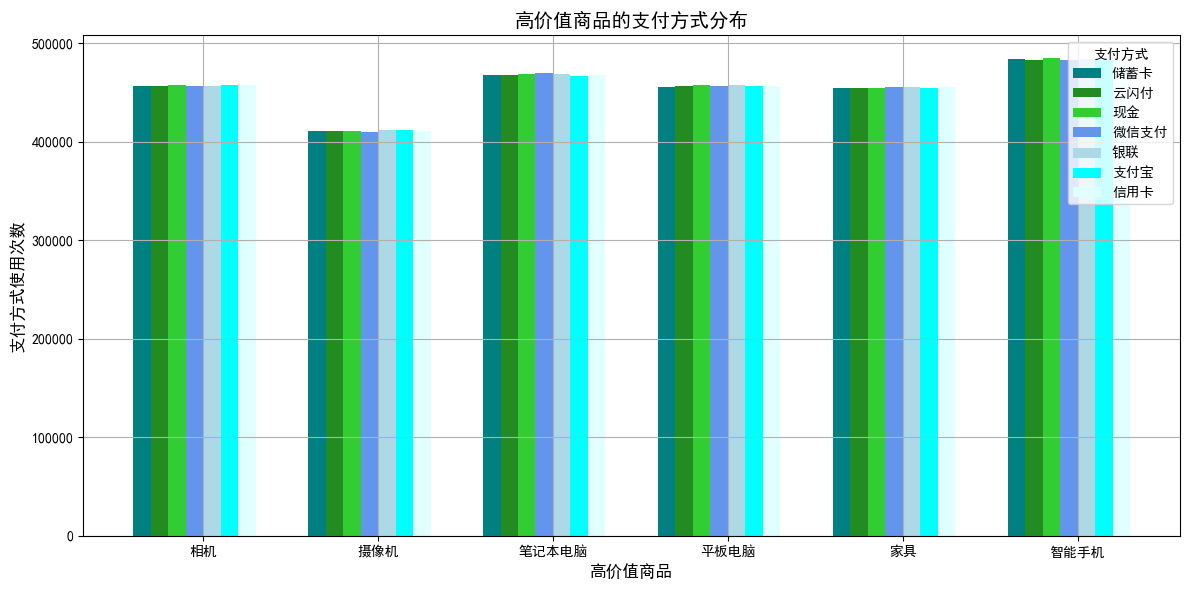

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = {item: Counter(hv_item_payment_map[item]) for item in hv_item_payment_map}

# 可视化：分组柱状图
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1
index = list(range(len(data)))
item_names = list(data.keys())
color = ['teal','forestgreen', 'limegreen', 'cornflowerblue', 'lightblue', 'cyan', 'lightcyan']
for i, payment in enumerate(pay_method):
    counts = [data[item].get(payment, 0) for item in item_names]
    bar_positions = [x + i * bar_width for x in index]
    ax.bar(bar_positions, counts, bar_width, label=payment,color = color[i])

# 设置图例和标签
ax.set_xlabel("高价值商品", fontsize=12)
ax.set_ylabel("支付方式使用次数", fontsize=12)
ax.set_title("高价值商品的支付方式分布", fontsize=14)
ax.set_xticks([x + bar_width * (len(pay_method) / 2) for x in index])
ax.set_xticklabels(item_names)
ax.legend(title="支付方式")
plt.tight_layout()
plt.grid()
plt.show()
